<h1>Nevan Ang Kai Wen
<h1>P2122867
<h1>Khor Yu Yang
<h1>P2123590
<h1>DAAA/FT/2B/01

References used


https://www.youtube.com/watch?v=SMZfgeHFFcA


https://www.youtube.com/watch?v=5fHngyN8Qhw&t=1727s

In [1]:
from keras.optimizers import Adam
import numpy as np
from keras.layers import Dense,Activation
from keras.models import Sequential,load_model
import datetime
import gym
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
tf.compat.v1.disable_eager_execution()

<h2>Replay Buffer

Storage of state,action,reward,state transition,tuples and done(terminal)

So that agent can use transitions to learn about parameter space of problem

In [5]:
class ReplayBuffer():
    def __init__(self,max_size,input_shape,n_actions,discrete=True):
        self.mem_size=max_size
        self.mem_cntr=0
        self.discrete=discrete #if dealt with discrete action space, we want to store them as vector
        self.state_mem=np.zeros((self.mem_size,input_shape))
        #to store new states of environment
        self.new_state_mem=np.zeros((self.mem_size,input_shape)) #track new states after each new action
        dtype=np.int8 if discrete else np.float32 #discrete or continuous
        self.action_mem=np.zeros((self.mem_size,n_actions),dtype=dtype)
        self.reward_mem=np.zeros(self.mem_size)
        self.terminal_mem=np.zeros(self.mem_size,dtype=np.float32) #determine whether episode is done, dont take in reward of next state
    #learn from its experiences by storing in info about its interactions
    def store_transition(self,state,action,reward,state_,terminal):
        index=self.mem_cntr %self.mem_size #from 0 to 1m size of memory, to replace exisiting when it hits 1m 
        self.state_mem[index]=state
        self.new_state_mem[index]=state_
        self.reward_mem[index]=reward
        self.terminal_mem[index]=1-int(terminal)# 1- true or 0
        if self.discrete: #one hot encoded actions
            actions=np.zeros(self.action_mem.shape[1])
            actions[action]=1.0
            self.action_mem[index]=actions
        else:
            self.action_mem[index]=action
        self.mem_cntr+=1
        
    def sample_memory(self,batch_size): # subset of memsize
        max_mem=min(self.mem_cntr,self.mem_size)#only sample from existing 
        batch=np.random.choice(max_mem,batch_size)
        states=self.state_mem[batch]
        states_=self.new_state_mem[batch]
        rewards=self.reward_mem[batch]
        actions=self.action_mem[batch]
        terminal=self.terminal_mem[batch]
        return states,actions, rewards,states_,terminal


In [6]:
def dqn(lr,n_actions,input_dim,fc1,fc2):
    model=Sequential([
        Dense(fc1,input_shape=(input_dim,)),#pass batch or single memory
        Activation('relu'),
        Dense(fc2),
        Activation('relu'),
        Dense(n_actions)
    ])
    model.compile(optimizer=Adam(lr=lr),loss='mse')
    return model


<h2>Agent W/ Target Network

Where the model is run, experience stored,action chosen, generate experience and learn and to save or load models

gamma-discount factor for future rewards


epsilon-random factor for epsilon greedy

In [7]:
class Agent():
    def __init__(self,alpha,gamma,n_actions,epsilon,batch_size,input_dims,epsilon_dec=0.996,epsilon_end=0.01,mem_size=1_000_000,fname='best_2_5_dqn_model.h5',replace=200):
        self.action_space=[i for i in range(n_actions)] # for randm action
        self.gamma=gamma
        self.epsilon=epsilon
        self.ep_dec=epsilon_dec
        self.eps_min=epsilon_end
        self.batch_size=batch_size
        self.model_file=fname
        self.step_counter=0
        self.update_rate=replace
        self.memory=ReplayBuffer(mem_size,input_dims,n_actions,discrete=True)
        self.Q_eval=dqn(alpha,n_actions,input_dims,150,130)
        self.Q_targetnet=dqn(alpha,n_actions,input_dims,150,130)
    #interfacing w/ memory to save new state transitions
    def remember(self,state,action,reward,new_state,terminal):
        self.memory.store_transition(state,action,reward,new_state,terminal)

    #epsilon greedy strategy
    def choose_action(self,state): #shaped input dims
        #reshape
        state=state[np.newaxis,:]
        rand=np.random.random()
        if rand<self.epsilon: #exploration
            action=np.random.choice(self.action_space)
        else:
            actions=self.Q_eval.predict(state,verbose=0)
            action=np.argmax(actions)#pass state through the network,get value of all actions and get max highest value
        return action

        ###Sample Memory,
        #Calculate value of current and next state
        #Update q_target based on next state as target for loss function of q_eval
    def learn(self):
        #Temporal difference learning method: learning every step, fill memory with random until batchsize
        if self.memory.mem_cntr<self.batch_size:
            return
        if self.step_counter % self.update_rate == 0:
            self.Q_targetnet.set_weights(self.Q_eval.get_weights())
        state,action,reward,new_state,terminal= self.memory.sample_memory(self.batch_size) #gives sample in shape batch_size
        action_values=np.array(self.action_space,dtype=np.int8)
        action_indices=np.dot(action,action_values) #from one hot to normal integer
        Q_eval=self.Q_eval.predict(state,verbose=0) #feed state through model to calculate current and next state 
        Q_next=self.Q_targetnet.predict(new_state,verbose=0)
        q_target=Q_eval.copy()
        #q-target in bellman equation
        #Address all states in particular batch, not normal array slicing because Shape(batchsize,batchsize) gives u wrong answer 
        batch_index=np.arange(self.batch_size,dtype=np.int32)
        q_target[batch_index,action_indices]= reward+self.gamma*np.max(Q_next,axis=1)*terminal #what q target shoots for
        #best possible reward received in next state 
        #0 to batchsize-1,action taken
        self.Q_eval.train_on_batch(state,q_target)#pass batch to network, compare to q target and 
        self.epsilon=self.epsilon*self.ep_dec if self.epsilon > self.eps_min else self.eps_min
        self.step_counter += 1
    def save_model(self,i):
        self.Q_eval.save(f'ep{i}_{self.model_file}')
    def load_model(self,name):
        self.Q_eval=load_model(name)
        

In [ ]:
env=gym.make("LunarLander-v2")
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


<h2>Training with 400 Episodes

In [ ]:
from torch.utils.tensorboard import SummaryWriter
agent=Agent(gamma=0.99,epsilon=1.0,alpha=0.001,input_dims=8,n_actions=4,batch_size=128,epsilon_end=0.01)
#agent scores
scores,eps_hist=[],[] #ontaining scores from each episode/epsiolon
# scores_window =[] #every 100 epsiode
episode=400
for i in range(episode):
    score=0
    terminate=False
    observation=env.reset()
    while not terminate:
        action=agent.choose_action(observation)
        observation_,reward,terminate,info=env.step(action)
        score+= reward
        agent.remember(observation,action,reward,observation_,terminate)
        observation=observation_
        agent.learn()
    scores.append(score)
    eps_hist.append(agent.epsilon)
    avg=np.mean(scores[max(0,i-100):(i+1)])#last 100 games
    print('Ep ',i+1, 'score %.2f'%score,'avg score %.2f'%avg,'epsilon %.2f'%agent.epsilon)
    if i%10==0 and i>0:
        agent.save_model(i)

env.close()

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Ep  1 score -202.70 avg score -202.70 epsilon 1.00


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Ep  2 score -52.22 avg score -127.46 epsilon 0.76
Ep  3 score -85.19 avg score -113.37 epsilon 0.52
Ep  4 score 229.16 avg score -27.74 epsilon 0.03
Ep  5 score -687.88 avg score -159.77 epsilon 0.02
Ep  6 score -366.77 avg score -194.27 epsilon 0.01
Ep  7 score -67.97 avg score -176.23 epsilon 0.01
Ep  8 score -389.43 avg score -202.88 epsilon 0.01
Ep  9 score -132.91 avg score -195.10 epsilon 0.01
Ep  10 score -528.12 avg score -228.40 epsilon 0.01
Ep  11 score -261.90 avg score -231.45 epsilon 0.01
Ep  12 score -214.19 avg score -230.01 epsilon 0.01
Ep  13 score -315.86 avg score -236.61 epsilon 0.01
Ep  14 score -380.86 avg score -246.92 epsilon 0.01
Ep  15 score -294.46 avg score -250.09 epsilon 0.01
Ep  16 score -13.92 avg score -235.33 epsilon 0.01
Ep  17 score -252.32 avg score -236.33 epsilon 0.01
Ep  18 score -132.78 avg score -230.57 epsilon 0.01
Ep  19 score -175.74 avg score -227.69 epsilon 0.01
Ep  20 score -166.84 avg score -224.65 epsilon 0.01
Ep  21 score -159.32 avg s

In [ ]:
agent.save_model(400)

In [8]:
def moving_average(a, n=100) : #calculating the average of a certain number of data points over a fixed period of time.
    #average of a certain number of consecutive data points, and then sliding the window of data points over the entire dataset, 
    #updating the average as the window moves. 
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
def plot_scores(scores):
    scores_ma=moving_average(scores,n=100)
    plt.plot(np.arange(len(scores_ma)), scores_ma)
    plt.ylabel('Score')
    plt.xlabel('Episode')
    plt.show()

<h2>Moving Average For 400 Epochs

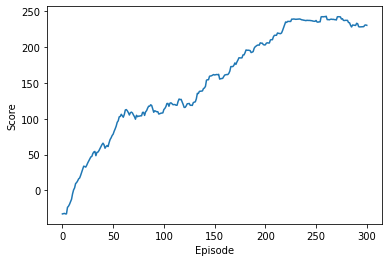

In [ ]:
plot_scores(scores)

<h2>Rewards for all episodes

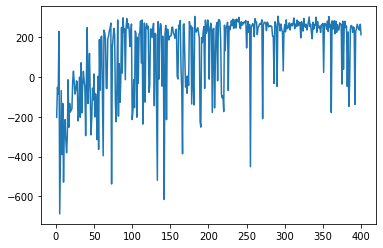

In [ ]:
plt.plot(x,scores)

<h2>Testing best model

In [9]:
!pip install tensorboardX tensorflow gymnasium numpy Box2D pygame #for colab
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate
!echo $DISPLAY
import pyvirtualdisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 27 not upgraded.
Need to get 990 kB of archives.
After this operation, 3,058 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libxxf86dga1 amd64 2:1.1.5-0ubuntu1 [12.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 x11-utils 

In [15]:
from gym.wrappers.record_video import RecordVideo
agent=Agent(gamma=0.99,epsilon=0,alpha=0.001,input_dims=8,n_actions=4,batch_size=128,epsilon_end=0.01)
agent.load_model('ep400_best_2_5_dqn_model.h5')
env=gym.make("LunarLander-v2")
scores=[]
env = gym.wrappers.RecordVideo(env, './test_lander', episode_trigger = lambda x: x % 10 == 0)
env.reset()
for i in range(100):
    score=0
    terminate=False
    observation=env.reset()
    while not terminate: #step count
        action=agent.choose_action(observation)
        observation_,reward,terminate,info=env.step(action)
        score+= reward
        observation=observation_
    scores.append(score)
    avg=np.mean(scores[max(0,i-100):(i+1)])#last 100 games
    print('Ep ',i+1, 'score %.2f'%score,'avg score %.2f'%avg,'epsilon %.2f'%agent.epsilon)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/test_lander folder (try specifying a different `video_folder` for t

Ep  1 score 254.37 avg score 254.37 epsilon 0.00
Ep  2 score 248.18 avg score 251.28 epsilon 0.00
Ep  3 score 250.67 avg score 251.08 epsilon 0.00
Ep  4 score 272.49 avg score 256.43 epsilon 0.00
Ep  5 score 270.23 avg score 259.19 epsilon 0.00
Ep  6 score 248.44 avg score 257.40 epsilon 0.00
Ep  7 score -69.11 avg score 210.75 epsilon 0.00
Ep  8 score 252.70 avg score 216.00 epsilon 0.00
Ep  9 score 43.33 avg score 196.81 epsilon 0.00


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Ep  10 score 205.66 avg score 197.70 epsilon 0.00
Ep  11 score 261.95 avg score 203.54 epsilon 0.00
Ep  12 score 278.75 avg score 209.80 epsilon 0.00
Ep  13 score 249.34 avg score 212.85 epsilon 0.00
Ep  14 score 87.80 avg score 203.91 epsilon 0.00
Ep  15 score -37.40 avg score 187.83 epsilon 0.00
Ep  16 score 246.35 avg score 191.48 epsilon 0.00
Ep  17 score 174.39 avg score 190.48 epsilon 0.00
Ep  18 score 264.02 avg score 194.56 epsilon 0.00
Ep  19 score 263.04 avg score 198.17 epsilon 0.00


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Ep  20 score 254.45 avg score 200.98 epsilon 0.00
Ep  21 score 262.94 avg score 203.93 epsilon 0.00
Ep  22 score 281.11 avg score 207.44 epsilon 0.00
Ep  23 score 149.89 avg score 204.94 epsilon 0.00
Ep  24 score 274.33 avg score 207.83 epsilon 0.00
Ep  25 score 265.45 avg score 210.13 epsilon 0.00
Ep  26 score 260.63 avg score 212.08 epsilon 0.00
Ep  27 score -59.18 avg score 202.03 epsilon 0.00
Ep  28 score 281.94 avg score 204.88 epsilon 0.00
Ep  29 score 263.91 avg score 206.92 epsilon 0.00


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Ep  30 score 279.05 avg score 209.32 epsilon 0.00
Ep  31 score 274.77 avg score 211.43 epsilon 0.00
Ep  32 score 285.91 avg score 213.76 epsilon 0.00
Ep  33 score 258.66 avg score 215.12 epsilon 0.00
Ep  34 score 241.47 avg score 215.90 epsilon 0.00
Ep  35 score 253.91 avg score 216.98 epsilon 0.00
Ep  36 score 295.47 avg score 219.16 epsilon 0.00
Ep  37 score -75.22 avg score 211.21 epsilon 0.00
Ep  38 score 262.37 avg score 212.55 epsilon 0.00
Ep  39 score 244.14 avg score 213.36 epsilon 0.00


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Ep  40 score 274.11 avg score 214.88 epsilon 0.00
Ep  41 score 277.76 avg score 216.42 epsilon 0.00
Ep  42 score 253.41 avg score 217.30 epsilon 0.00
Ep  43 score 240.78 avg score 217.84 epsilon 0.00
Ep  44 score 262.45 avg score 218.86 epsilon 0.00
Ep  45 score -129.40 avg score 211.12 epsilon 0.00
Ep  46 score 260.20 avg score 212.18 epsilon 0.00
Ep  47 score 263.69 avg score 213.28 epsilon 0.00
Ep  48 score -258.40 avg score 203.45 epsilon 0.00
Ep  49 score 234.41 avg score 204.09 epsilon 0.00


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Ep  50 score 258.17 avg score 205.17 epsilon 0.00
Ep  51 score 282.54 avg score 206.68 epsilon 0.00
Ep  52 score 251.64 avg score 207.55 epsilon 0.00
Ep  53 score 270.91 avg score 208.74 epsilon 0.00
Ep  54 score 280.55 avg score 210.07 epsilon 0.00
Ep  55 score 251.80 avg score 210.83 epsilon 0.00
Ep  56 score -108.71 avg score 205.13 epsilon 0.00
Ep  57 score 217.92 avg score 205.35 epsilon 0.00
Ep  58 score 203.88 avg score 205.33 epsilon 0.00
Ep  59 score 247.22 avg score 206.04 epsilon 0.00


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Ep  60 score 226.68 avg score 206.38 epsilon 0.00
Ep  61 score 282.73 avg score 207.63 epsilon 0.00
Ep  62 score 284.70 avg score 208.87 epsilon 0.00
Ep  63 score 248.98 avg score 209.51 epsilon 0.00
Ep  64 score 263.01 avg score 210.35 epsilon 0.00
Ep  65 score 281.31 avg score 211.44 epsilon 0.00
Ep  66 score 267.06 avg score 212.28 epsilon 0.00
Ep  67 score 273.23 avg score 213.19 epsilon 0.00
Ep  68 score 254.56 avg score 213.80 epsilon 0.00
Ep  69 score 268.06 avg score 214.59 epsilon 0.00


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Ep  70 score 251.44 avg score 215.11 epsilon 0.00
Ep  71 score 205.16 avg score 214.97 epsilon 0.00
Ep  72 score 260.82 avg score 215.61 epsilon 0.00
Ep  73 score 260.53 avg score 216.22 epsilon 0.00
Ep  74 score 268.07 avg score 216.93 epsilon 0.00
Ep  75 score 131.73 avg score 215.79 epsilon 0.00
Ep  76 score 42.30 avg score 213.51 epsilon 0.00
Ep  77 score 236.49 avg score 213.80 epsilon 0.00
Ep  78 score 176.13 avg score 213.32 epsilon 0.00
Ep  79 score -123.80 avg score 209.05 epsilon 0.00


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Ep  80 score -103.06 avg score 205.15 epsilon 0.00
Ep  81 score 280.71 avg score 206.09 epsilon 0.00
Ep  82 score -366.60 avg score 199.10 epsilon 0.00
Ep  83 score 282.61 avg score 200.11 epsilon 0.00
Ep  84 score 234.71 avg score 200.52 epsilon 0.00
Ep  85 score 261.21 avg score 201.23 epsilon 0.00
Ep  86 score 262.43 avg score 201.95 epsilon 0.00
Ep  87 score 231.52 avg score 202.29 epsilon 0.00
Ep  88 score 241.15 avg score 202.73 epsilon 0.00
Ep  89 score 261.41 avg score 203.39 epsilon 0.00


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Ep  90 score 247.48 avg score 203.88 epsilon 0.00
Ep  91 score 279.77 avg score 204.71 epsilon 0.00
Ep  92 score -186.37 avg score 200.46 epsilon 0.00
Ep  93 score 262.65 avg score 201.13 epsilon 0.00
Ep  94 score 213.58 avg score 201.26 epsilon 0.00
Ep  95 score 236.90 avg score 201.64 epsilon 0.00
Ep  96 score 245.75 avg score 202.10 epsilon 0.00
Ep  97 score 266.74 avg score 202.76 epsilon 0.00
Ep  98 score 243.23 avg score 203.18 epsilon 0.00
Ep  99 score 298.24 avg score 204.14 epsilon 0.00
Ep  100 score 260.79 avg score 204.70 epsilon 0.00


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [16]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('./test_lander/rl-video-episode-90.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 height = 400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

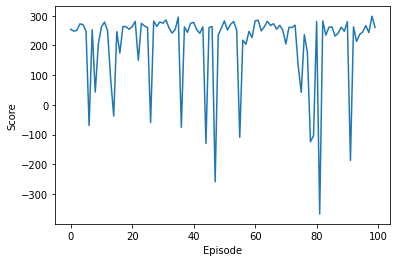

In [19]:
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()